In [2]:
#Code Source: https://www.kaggle.com/dragonoken/churn-modelling-with-pytorch/notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns

### Data Reviewing

In [3]:
os.chdir("C:\\Users\\kusalh\\Documents\\Courses")
BD = pd.read_csv('Courses.csv')
BD.head()

,ID,course,completed,upgraded,gender,country,age,education,job,major,...,completion_year,completion_month,completion_day,completion_hour,completion_minute,upgrade_year,upgrade_month,upgrade_day,upgrade_hour,upgrade_minute
0,284921427,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,284926400,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,284946595,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,285755462,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,285831220,1,1,0,0,0,0,0,0,0,...,2011,5,29,15,58,0,0,0,0,0


### Preprocessing 

### Moving on to Pytorch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from collections import OrderedDict

In [32]:
#After all data converted to numerical values, put them into a matrix!
# features = np.array(BD.drop('upgraded', axis=1))
DF = BD.drop([
            'ID',
            'upgraded',
            'registration_year',
            'registration_month',
            'registration_day',
            'registration_hour',
            'registration_minute',
            'withdrawl_year',
            'withdrawl_month',
            'withdrawl_day',
            'withdrawl_hour',
            'withdrawl_minute',
            'completion_year',
            'completion_month',
            'completion_day',
            'completion_hour',
            'completion_minute',
            'upgrade_year',
            'upgrade_month',
            'upgrade_day',
            'upgrade_hour',
            'upgrade_minute'
        ], axis=1)
features = np.array(DF)
feature_names = DF.columns.tolist()
labels = np.array(BD['upgraded'])
features, feature_names, labels

(array([[  1,   0,   0, ...,   0,   0,   0],
        [  1,   0,   0, ...,   0,   0,   0],
        [  1,   0,   0, ...,   0,   0,   0],
        ...,
        [  3,   0,   0, ...,   0,   0, 171],
        [  3,   0,   0, ...,   0,   0,  56],
        [  3,   0,   0, ...,   0,   0,  51]], dtype=int64),
 ['course',
  'completed',
  'gender',
  'country',
  'age',
  'education',
  'job',
  'major',
  'logged_location'],
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [40]:
DF.corr()
# BD['upgraded'].sum()
# BD['upgraded'].nunique()
# BD['upgraded'].unique()

# features

,course,completed,gender,country,age,education,job,major,logged_location
course,1.000000,-0.109023,0.044043,0.058997,0.042498,0.045879,0.038253,0.045598,0.642345
completed,-0.109023,1.000000,0.112876,0.067547,0.095586,0.109545,0.101928,0.074955,-0.093834
gender,0.044043,0.112876,1.000000,0.769198,0.754941,0.899909,0.855397,0.736603,0.045275
country,0.058997,0.067547,0.769198,1.000000,0.677937,0.805141,0.745185,0.682047,0.145091
age,0.042498,0.095586,0.754941,0.677937,1.000000,0.740357,0.647954,0.582312,0.039445
education,0.045879,0.109545,0.899909,0.805141,0.740357,1.000000,0.897418,0.785707,0.049138
job,0.038253,0.101928,0.855397,0.745185,0.647954,0.897418,1.000000,0.799745,0.040760
major,0.045598,0.074955,0.736603,0.682047,0.582312,0.785707,0.799745,1.000000,0.050826
logged_location,0.642345,-0.093834,0.045275,0.145091,0.039445,0.049138,0.040760,0.050826,1.000000


### Create a custom dataset

In [42]:
class MOOC(Dataset):
    def __init__(self):
        global features, labels
        assert features.shape[0] == labels.shape[0], "The lengths of features and labels do not match"

        self.feature_names = feature_names
        self.features = torch.tensor(features, dtype=torch.float)
        self.labels = torch.tensor(labels)
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])
    
    def get_feature_names(self):
        return self.feature_names

dataset = MOOC()
len(dataset), dataset[0], len(dataset.get_feature_names())

(25000, (tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor(0)), 9)

### Create 2 dataloaders: a training set loader and a validation set loader.

In [8]:
test_size = 0.1
shuffle = True

# Taking the same proportion of examples from both classes
true_idx = dataset[:][1].eq(1).nonzero().view(-1).long()
false_idx = dataset[:][1].eq(0).nonzero().view(-1).long()

t_new_idx = true_idx[torch.randperm(len(true_idx))] if shuffle else true_idx
f_new_idx = false_idx[torch.randperm(len(false_idx))] if shuffle else false_idx

# trying out matching the number of examples for each class
f_new_idx = f_new_idx[:(len(t_new_idx) // 2) * 2]

t_test_len = int(round(len(t_new_idx) * test_size))
f_test_len = int(round(len(f_new_idx) * test_size))
train_idx = torch.cat((t_new_idx[:len(t_new_idx) - t_test_len], f_new_idx[:len(f_new_idx) - f_test_len]))
validation_idx = torch.cat((t_new_idx[len(t_new_idx) - t_test_len:], f_new_idx[len(f_new_idx) - f_test_len:]))

train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

trainloader = DataLoader(dataset, batch_size=len(train_sampler), sampler=train_sampler)
validationloader = DataLoader(dataset, batch_size=len(validation_sampler), sampler=validation_sampler)
len(trainloader), len(train_sampler), len(validationloader), len(validation_sampler), next(iter(trainloader))

(1,
 375,
 1,
 42,
 [tensor([[1.0867e+09, 3.0000e+00, 1.0000e+00,  ..., 1.8000e+01, 1.4000e+01,
           1.0000e+00],
          [1.0805e+09, 3.0000e+00, 1.0000e+00,  ..., 1.8000e+01, 1.8000e+01,
           2.4000e+01],
          [1.2276e+09, 2.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          ...,
          [5.7871e+08, 1.0000e+00, 1.0000e+00,  ..., 1.6000e+01, 1.7000e+01,
           1.7000e+01],
          [1.2149e+09, 2.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [5.4757e+08, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]]),
  tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
          1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
          1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
          1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
          0, 1, 0, 0, 0, 1, 1,

## Building the model

In [9]:
class NAC(nn.Module):
    """Neural Accumulator from Google Deepmind"""
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.sigmoid_weight = nn.Parameter(init.xavier_normal_(torch.empty(in_features, out_features)))
        self.tanh_weight = nn.Parameter(init.xavier_normal_(torch.empty(in_features, out_features)))
        
    def forward(self, x):
        W = self.sigmoid_weight.sigmoid() * self.tanh_weight.tanh()
        a = torch.mm(x, W)
        return a
    
    def extra_repr(self):
        return f"in_features={self.in_features}, out_features={self.out_features}"

class NALU(nn.Module):
    """Neural Arithmetic Logic Unit from Google Deepmind"""
    def __init__(self, in_features, out_features, epsilon=1e-8):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.epsilon = epsilon

        self.gate_weight = nn.Parameter(init.xavier_normal_(torch.empty(in_features, 1)))
        self.accumulator = NAC(in_features, out_features)
        self.multiplier = NAC(in_features, out_features)
        
    def forward(self, x):
        a = self.accumulator(x)
        m = torch.exp(self.multiplier(torch.log(x.abs() + self.epsilon)))
        g = torch.mm(x, self.gate_weight)
        
        y = g * a + (1 - g) * m
        return y
    
    def extra_repr(self):
        return f"in_features={self.in_features}, out_features={self.out_features}, epsilon={self.epsilon}"

class ChurnClassifier(nn.Module):
    def __init__(self, in_features, out_features, hidden_sizes=[], dropout=0):
        super().__init__()

        # Constructing layers
        previous_size = in_features
        for layer_num, hidden_size in enumerate(hidden_sizes, 1):
            self.add_module(f"hidden_layer{layer_num}",
                nn.Sequential(
                    OrderedDict(
                        [
                            ('fc', nn.Linear(previous_size, hidden_size)),
                            ('relu', nn.ReLU()),
                            ('norm', nn.LayerNorm(hidden_size)),
                            ('dropout', nn.Dropout(p=dropout))
                        ]
                    )
                )
            )
            previous_size = hidden_size

        self.add_module("output_layer",
            nn.Sequential(
                OrderedDict(
                    [
                        ('fc', nn.Linear(previous_size, out_features))
                    ]
                )
            )
        )
        
        self.initialize_weights()
        
    def forward(self, x):
        # Process the input sequentially through the layers of the model
        for layer in self.children():
            x = layer(x)
        
        return x
    
    def num_params(self, trainable_only=False):
        # Total number of parameters
        if trainable_only:
            return sum(param.numel() for param in self.parameters() if param.requires_grad)
        else:
            return sum(param.numel() for param in self.parameters())
        
    def initialize_weights(self):
        # Initialize the weights and biases
        for param in self.parameters():
            if len(param.shape) > 1:
                init.xavier_normal_(param.data)
            else:
                param.data.zero_()
                
class ChurnClassifierWithNALU(nn.Module):
    def __init__(self, in_features, out_features, nalu_sizes=[], hidden_sizes=[], dropout=0, epsilon=1e-8, input_normalize=True):
        super().__init__()
        
        # Layers
        if input_normalize:
            self.add_module('norm0', nn.LayerNorm(in_features))

        previous_size = in_features

        if len(nalu_sizes) != 0:
            nalu_layers = OrderedDict()
            for layer_num, nalu_size in enumerate(nalu_sizes, 1):
                nalu_layers[f"nalu_layer{layer_num}"] = nn.Sequential(OrderedDict([
                    ('nalu', NALU(previous_size, nalu_size, epsilon=epsilon)),
                    ('norm', nn.LayerNorm(nalu_size)),
                    ('dropout', nn.Dropout(p=dropout))
                ]))
                previous_size = nalu_size
            self.add_module('nalu_layers', nn.Sequential(nalu_layers))
        
        self.add_module('classifier', ChurnClassifier(in_features=previous_size, out_features=out_features, hidden_sizes=hidden_sizes, dropout=dropout))
        
    def forward(self, x):
        # Process the input sequentially through the layers of the model
        for layer in self.children():
            x = layer(x)
        
        return x
    
    def num_params(self, trainable_only=False):
        # Total number of parameters
        if trainable_only:
            return sum(param.numel() for param in self.parameters() if param.requires_grad)
        else:
            return sum(param.numel() for param in self.parameters())
        
    def initialize_weights(self):
        # Initialize the weights and biases
        for param in self.parameters():
            if len(param.shape) > 1:
                init.xavier_normal_(param.data)
            else:
                param.data.zero_()

In [10]:
model = ChurnClassifierWithNALU(in_features=30, out_features=2, nalu_sizes=[], hidden_sizes=[500, 500, 500, 500], dropout=0.2)
print(model)
print("Total number of trainable parameters :", model.num_params(True))

ChurnClassifierWithNALU(
  (norm0): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
  (classifier): ChurnClassifier(
    (hidden_layer1): Sequential(
      (fc): Linear(in_features=30, out_features=500, bias=True)
      (relu): ReLU()
      (norm): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (hidden_layer2): Sequential(
      (fc): Linear(in_features=500, out_features=500, bias=True)
      (relu): ReLU()
      (norm): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (hidden_layer3): Sequential(
      (fc): Linear(in_features=500, out_features=500, bias=True)
      (relu): ReLU()
      (norm): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (hidden_layer4): Sequential(
      (fc): Linear(in_features=500, out_features=500, bias=True)
      (relu): ReLU()
      (norm): LayerNorm((500,), eps=1e-0

### Training the model

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.0, weight_decay=0.01)

In [12]:
epoch = 0
train_logs = {'losses': [], 'accuracies': [], 'recalls': [], 'precisions': [], 'f1_scores': []}
validation_logs = {'losses': [], 'accuracies': [], 'recalls': [], 'precisions': [], 'f1_scores': []}

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)
criterion.to(device)
model.train()

epochs = 1000
print_every = 50  # epochs
# threshold = 0.5  # prediction value greater than this is interpreted as a prediction of 1

for e in range(epochs):
    running_train_loss = 0
    running_train_accuracy = 0
    running_train_recall = 0
    running_train_precision = 0
    running_train_f1 = 0
    for features, labels in trainloader:
        features = features.to(device)
        labels = labels.to(device)
        
        output = model(features)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        current_loss = loss.item()
        current_accuracy = torch.mean((output.argmax(dim=1) == labels).type(torch.FloatTensor)).item()
        current_recall = torch.mean((output.argmax(dim=1) == labels)[labels == 1].type(torch.FloatTensor)).item()
        current_precision = torch.mean((output.argmax(dim=1) == labels)[output.argmax(dim=1) == 1].type(torch.FloatTensor)).item() if (output.argmax(dim=1) == 1).sum() != 0 else 0
        current_f1 = 2 * current_recall * current_precision / (current_recall + current_precision) if current_recall > 0 and current_precision > 0 else 0

        running_train_loss += current_loss * features.shape[0]
        running_train_accuracy += current_accuracy * features.shape[0]
        running_train_recall += current_recall * features.shape[0]
        running_train_precision += current_precision * features.shape[0]
        running_train_f1 += current_f1 * features.shape[0]
    running_train_loss /= len(trainloader.sampler)
    running_train_accuracy /= len(trainloader.sampler)
    running_train_recall /= len(trainloader.sampler)
    running_train_precision /= len(trainloader.sampler)
    running_train_f1 /= len(trainloader.sampler)
    
    
    
    model.eval()
    running_validation_loss = 0
    running_validation_accuracy = 0
    running_validation_recall = 0
    running_validation_precision = 0
    running_validation_f1 = 0
    with torch.no_grad():
        for features, labels in validationloader:
            features = features.to(device)
            labels = labels.to(device)

            output = model(features)
            loss = criterion(output, labels)

            current_loss = loss.item()
            current_accuracy = torch.mean((output.argmax(dim=1) == labels).type(torch.FloatTensor)).item()
            current_recall = torch.mean((output.argmax(dim=1) == labels)[labels == 1].type(torch.FloatTensor)).item()
            current_precision = torch.mean((output.argmax(dim=1) == labels)[output.argmax(dim=1) == 1].type(torch.FloatTensor)).item() if (output.argmax(dim=1) == 1).sum() != 0 else 0
            current_f1 = 2 * current_recall * current_precision / (current_recall + current_precision) if current_recall > 0 and current_precision > 0 else 0

            running_validation_loss += current_loss * features.shape[0]
            running_validation_accuracy += current_accuracy * features.shape[0]
            running_validation_recall += current_recall * features.shape[0]
            running_validation_precision += current_precision * features.shape[0]
            running_validation_f1 += current_f1 * features.shape[0]
    running_validation_loss /= len(validationloader.sampler)
    running_validation_accuracy /= len(validationloader.sampler)
    running_validation_recall /= len(validationloader.sampler)
    running_validation_precision /= len(validationloader.sampler)
    running_validation_f1 /= len(validationloader.sampler)
    model.train()
    
    train_logs['losses'].append(running_train_loss)
    train_logs['accuracies'].append(running_train_accuracy)
    train_logs['recalls'].append(running_train_recall)
    train_logs['precisions'].append(running_train_precision)
    train_logs['f1_scores'].append(running_train_precision)
    validation_logs['losses'].append(running_validation_loss)
    validation_logs['accuracies'].append(running_validation_accuracy)
    validation_logs['recalls'].append(running_validation_recall)
    validation_logs['precisions'].append(running_validation_precision)
    validation_logs['f1_scores'].append(running_validation_precision)
    
    if e == 0 or (e + 1) % print_every == 0:
        print(f"Epoch : {epoch}")
        print(f"Training Loss : {running_train_loss}")
        print(f"Training Accuracy : {round(running_train_accuracy * 100, 2)}%")
        print(f"Training Recall : {round(running_train_recall * 100, 2)}%")
        print(f"Training Precision : {round(running_train_precision * 100, 2)}%")
        print(f"Training F1 Score : {round(running_train_f1, 4)}")
        print(f"Validation Loss : {running_validation_loss}")
        print(f"Validation Accuracy : {round(running_validation_accuracy * 100, 2)}%")
        print(f"Validation Recall : {round(running_validation_recall * 100, 2)}%")
        print(f"Validation Precision : {round(running_validation_precision * 100, 2)}%")
        print(f"Validation F1 Score : {round(running_validation_f1, 4)}")
        print()
    
    epoch += 1

Epoch : 0
Training Loss : 0.6931459903717041
Training Accuracy : 50.13%
Training Recall : 100.0%
Training Precision : 50.13%
Training F1 Score : 0.6679
Validation Loss : 21.976137161254883
Validation Accuracy : 50.0%
Validation Recall : 0.0%
Validation Precision : 0.0%
Validation F1 Score : 0.0

Epoch : 49
Training Loss : 1.8508789539337158
Training Accuracy : 49.87%
Training Recall : 0.0%
Training Precision : 0.0%
Training F1 Score : 0.0
Validation Loss : 1.9692168235778809
Validation Accuracy : 50.0%
Validation Recall : 100.0%
Validation Precision : 50.0%
Validation F1 Score : 0.6667

Epoch : 99
Training Loss : 0.7159985899925232
Training Accuracy : 49.87%
Training Recall : 0.0%
Training Precision : 0.0%
Training F1 Score : 0.0
Validation Loss : 0.7083967924118042
Validation Accuracy : 50.0%
Validation Recall : 0.0%
Validation Precision : 0.0%
Validation F1 Score : 0.0

Epoch : 149
Training Loss : 0.6931471228599548
Training Accuracy : 50.13%
Training Recall : 0.53%
Training Precisio

### Visualising the training process

C:\Users\kusalh\AppData\Local\Continuum\miniconda3\envs\course\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


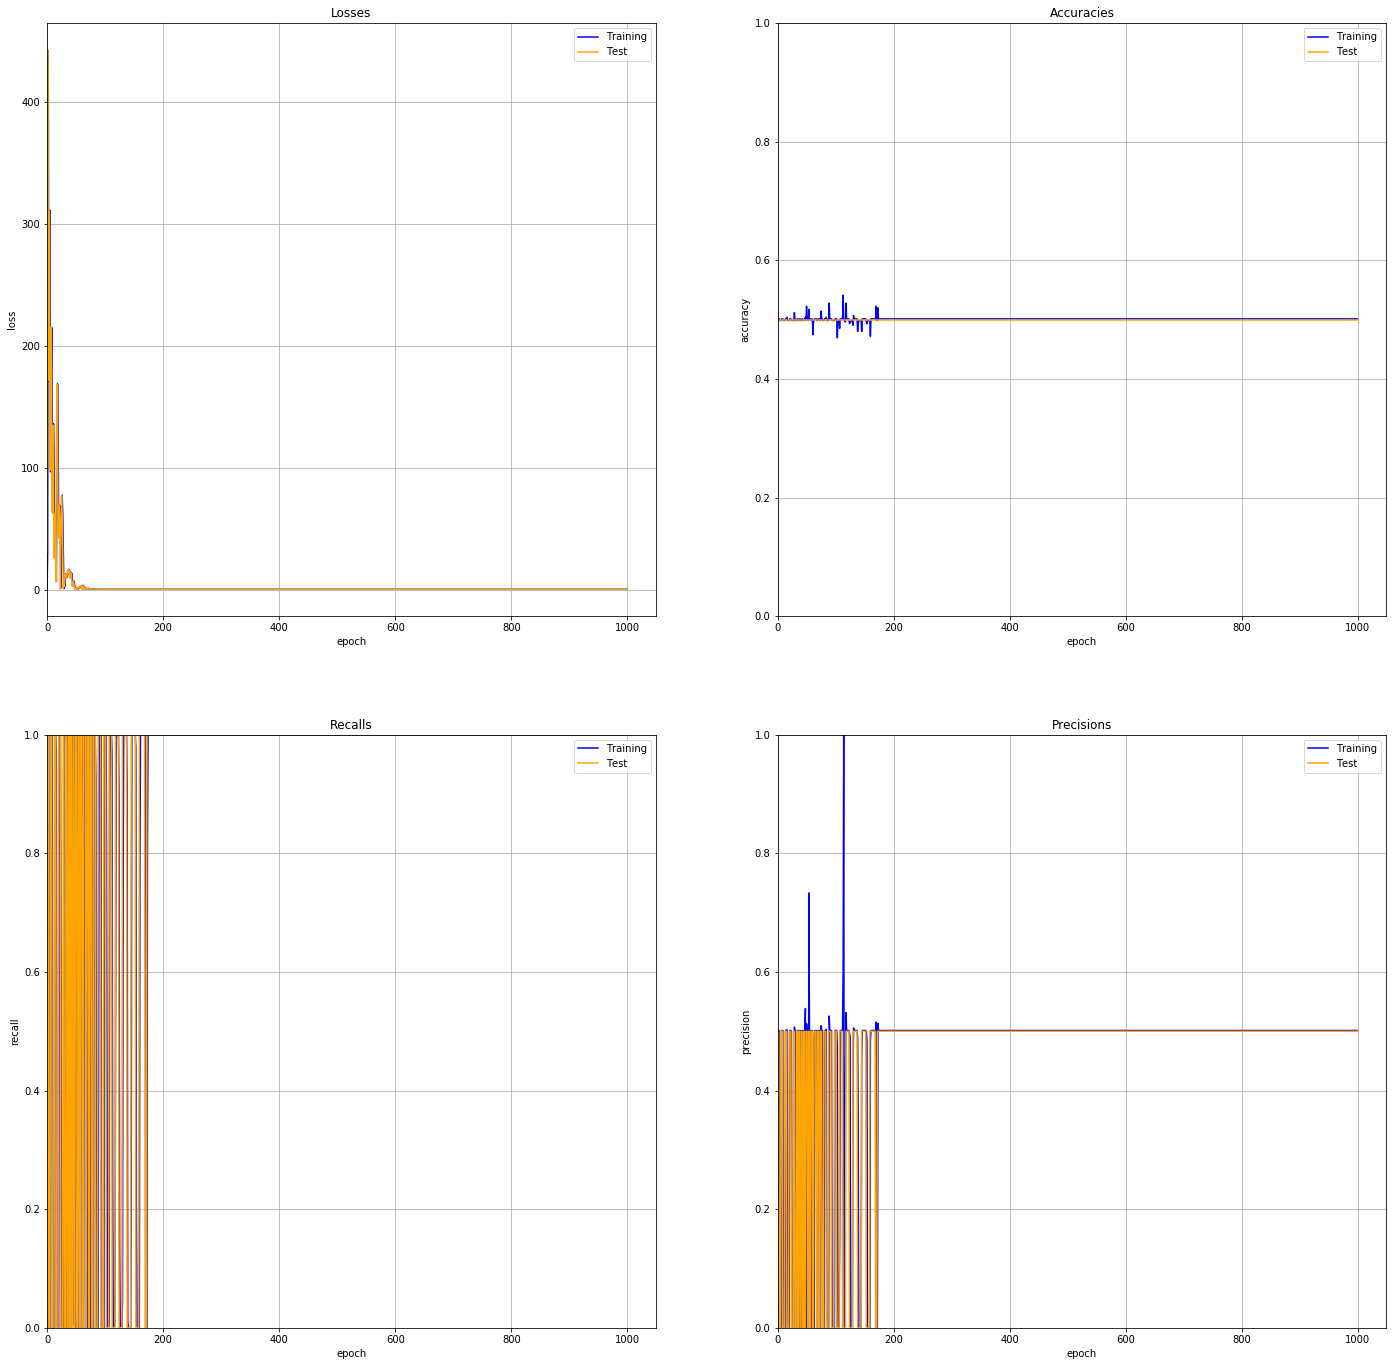

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(24, 24))

axes[0, 0].set_title('Losses')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel("loss")
axes[0, 0].grid()
axes[0, 0].plot(range(len(train_logs['losses'])), train_logs['losses'], color='blue')
axes[0, 0].plot(range(len(train_logs['losses'])), validation_logs['losses'], color='orange')
axes[0, 0].set_xlim((0, None))
axes[0, 0].legend(['Training', 'Test'])

axes[0, 1].set_title('Accuracies')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel("accuracy")
axes[0, 1].grid()
axes[0, 1].plot(range(len(train_logs['accuracies'])), train_logs['accuracies'], color='blue')
axes[0, 1].plot(range(len(train_logs['accuracies'])), validation_logs['accuracies'], color='orange')
axes[0, 1].set_xlim((0, None))
axes[0, 1].set_ylim((0, 1))
axes[0, 1].legend(['Training', 'Test'])

axes[1, 0].set_title('Recalls')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel("recall")
axes[1, 0].grid()
axes[1, 0].plot(range(len(train_logs['recalls'])), train_logs['recalls'], color='blue')
axes[1, 0].plot(range(len(train_logs['recalls'])), validation_logs['recalls'], color='orange')
axes[1, 0].set_xlim((0, None))
axes[1, 0].set_ylim((0, 1))
axes[1, 0].legend(['Training', 'Test'])

axes[1, 1].set_title('Precisions')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_ylabel("precision")
axes[1, 1].grid()
axes[1, 1].plot(range(len(train_logs['precisions'])), train_logs['precisions'], color='blue')
axes[1, 1].plot(range(len(train_logs['precisions'])), validation_logs['precisions'], color='orange')
axes[1, 1].set_xlim((0, None))
axes[1, 1].set_ylim((0, 1))
axes[1, 1].legend(['Training', 'Test'])

fig.show();